# Coursework 2 : Movie Recommendation based on Graph


In [1]:
from collections import Counter
from tqdm import tqdm
import math
import pandas as pd
import numpy as np
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import json
import time
import itertools
import collections


%matplotlib inline

## Movies linked thorugh Actors playing characters

### Loading movies data and also actors/characters data

Character table structure

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID

In [2]:
movies_meta=pd.read_csv("data/movie.metadata.tsv", 
                         sep='\t', header=None, usecols=[0,1,2,3,8], 
                         names=['wID', 'fID', 'title', 'date', 'genres'],
                         parse_dates=[3]
                       )
# All movies have at least one character
char_meta = pd.read_csv("data/character.metadata.tsv", 
                         sep='\t', header=None, usecols=[0,3,7,8,11, 12], 
                         names=['wID', 'char_name', 'ethnicity', 'act_name', 'fcID', 'faID'])


# We filter out movies released before 1997
movies_filtered = movies_meta[movies_meta.date.str.match('199[7-9]$|20..$|^20..|^199[7-9]')]
mIDs = set(movies_filtered.wID)
char_filtered = char_meta[char_meta.wID.isin(mIDs)]

## TODO: Add tvtropes
print("Retrieved {} movies".format(len(movies_meta)))
print("Retrieved {} characters".format(len(char_meta)))

print("Kept {} movies".format(len(movies_filtered)))
print("Kept {} characters".format(len(char_filtered)))

movies_meta = movies_filtered
char_meta = char_filtered

Retrieved 81741 movies
Retrieved 450669 characters
Kept 27782 movies
Kept 201536 characters


In [3]:
## Contents of the table for characters/actors
char_meta.head()

,wID,char_name,ethnicity,act_name,fcID,faID
0,975900,Akooshay,NaN,Wanda De Jesus,/m/0bgcj3x,/m/03wcfv7
1,975900,Lieutenant Melanie Ballard,/m/044038p,Natasha Henstridge,/m/0bgchn4,/m/0346l4
2,975900,Desolation Williams,/m/0x67,Ice Cube,/m/0bgchn_,/m/01vw26l
3,975900,Sgt Jericho Butler,NaN,Jason Statham,/m/0bgchnq,/m/034hyc
4,975900,Bashira Kincaid,NaN,Clea DuVall,/m/0bgchp9,/m/01y9xg


In [4]:
## Contents of the table for movies
movies_meta.head()

,wID,fID,title,date,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,"{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant..."
12,6631279,/m/0gffwj,Little city,1997-04-04,"{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ..."
21,612710,/m/02wjqm,New Rose Hotel,1999-10-01,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."


## Build a graph

**In the following we first build a complex large graph with movies, characters/actors, (if we want ethnicity).**

**Later we will keep only a smaller version of it.**

Process characters and connect with movies, also add movies and actor edges. 

In [7]:
movieG = nx.DiGraph(name='Movie graph')

# Add movies as nodes
for i,movie in tqdm(movies_meta.iterrows(), total=len(movies_meta)): 
    movieG.add_node(movie['wID'], title = movie['title'], date = movie['date'], type='movie')


# Process the characters and connect with movies
for i,character in tqdm(char_meta.iterrows(), total=len(char_meta)):
    if not pd.isnull(character['fcID']):  # Check not null
        movieG.add_node(character['fcID'], name = character['char_name'], type = 'character')
        movieG.add_edge(character['wID'], character['fcID'], label='has_character')
        movieG.add_edge(character['fcID'], character['wID'], label='character_of')
        
    if not pd.isnull(character['faID']): 
        movieG.add_node(character['faID'], name = character['act_name'], type = 'actor')
        movieG.add_edge(character['wID'], character['faID'], label='has_actor')
        movieG.add_edge(character['faID'], character['wID'], label='actor_of')
        
    #if not pd.isnull(character['ethnicity']): 
    #    movieG.add_edge(character['fcID'], character['ethnicity'], label='ethnicity')



100%|██████████| 201536/201536 [00:40<00:00, 5009.51it/s]


#### Process movie metadata and add genres 

**We enrich the graph with nodes about movie-genres**

Add meta information to movies

In [8]:
genres_all = Counter() 
genre_names = {}
for i,movie in tqdm(movies_meta.iterrows(), total=len(movies_meta)):     
    genres = json.loads(movie['genres'])
    for gid, genre in genres.items() : 
        if not gid in genres_all:
            genres_all[gid] = 1
            genre_names[gid] = genre
            movieG.add_node(gid, title = genre, type='genre')
        else:
            genres_all.update({gid : 1})
            
        movieG.add_edge(movie['wID'], gid, label='has_genre')
        movieG.add_edge(gid, movie['wID'], label='genre_of')        
        
print("Num genres {}".format(len(genres_all)))
for gid, c in genres_all.most_common(10):
    print("{} # {}".format(genre_names[gid], c))

100%|██████████| 27782/27782 [00:05<00:00, 4856.79it/s]

Num genres 320
Drama # 12200
Comedy # 6036
Romance Film # 4323
Thriller # 4303
World cinema # 4121
Action # 3528
Documentary # 3186
Indie # 2966
Horror # 2482
Crime Fiction # 2385


#### Print some statistics of the large graph

In [ ]:
print(nx.info(movieG))
print('Number of connected components: ', nx.number_weakly_connected_components(movieG))

## Smaller graph 

#### Filter dangling nodes and small connected components
This is the first step in cleaning the graph to keep only a smaller version.

In [ ]:
# We search for the largest connected component
max_comp = max(nx.weakly_connected_components(movieG), key=len)

# We remove all nodes in other components
to_remove = set() 
for i,node in tqdm(enumerate(movieG.nodes), total=movieG.number_of_nodes()) : 
    if node not in max_comp : 
        to_remove.add(node)
movieG.remove_nodes_from(to_remove)
print(nx.info(movieG))
print('Number of connected components: ', nx.number_weakly_connected_components(movieG))

### Undirected graph 

Construct an undirected graph with less nodes and only movies connected one to the other

**Two nodes are connected if they have an actor in common**

In [9]:
# New graph, this will be undirected
movieSG = nx.Graph(name='Movie undirected graph')

for i,(nid, node) in tqdm(enumerate(movieG.nodes(data=True)), total=movieG.number_of_nodes()) : 
    # Get all movies for an actor, and link those movies
    if 'type' in node and (node['type'] == 'actor') : 
        movies = set()
        for destid, dest in movieG[nid].items():
            if dest['label'] == 'actor_of': 
                movies.add(destid)
        # two edges are added so they are undirected                
        for m1, m2 in itertools.combinations(movies, 2): 
            movieSG.add_edge(m1, m2)
    # Get all movies for a genrse, and link those movies  
    # This will cause too many links, can we filter out some?
    # https://networkx.github.io/documentation/stable/reference/classes/generated/networkx.Graph.degree.html ?
#     if 'type' in node and (node['type'] == 'genre') : 
#         movies = set()
#         for destid, dest in movieG[nid].items():
#             if dest['label'] == 'genre_of': 
#                 movies.add(destid)
#         # two edges are added so they are undirected
#         for m1, m2 in itertools.combinations(movies, 2): 
#             movieSG.add_edge(m1, m2)   

print("Done")

100%|██████████| 208278/208278 [00:02<00:00, 83696.68it/s] 

Done


In [ ]:
print(nx.info(movieSG))

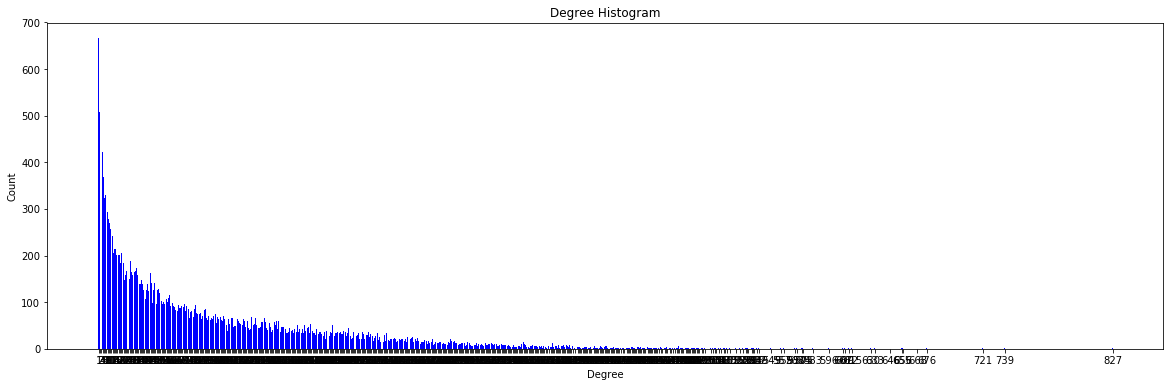

In [10]:
degree_sequence = sorted([d for n, d in movieSG.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots(figsize=(20, 6))
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)
plt.show()

Compute the Personalized PageRank on the small graph

In [11]:
def pagerank(G, p = None): 
    t = time.time()
    pr = nx.pagerank_scipy(G, personalization= p, max_iter=200)
    print('scipy PR {} seconds'.format(time.time() - t))
    return pr
#print(pr)

In [12]:
movies_meta[movies_meta.title.str.match('.*Lord of.*')]

,wID,fID,title,date,genres
8821,173944,/m/017gm7,The Lord of the Rings: The Two Towers,2002-12-05,"{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj..."
14677,11310190,/m/02r775q,Ringers: Lord of the Fans,2005,"{""/m/0hj3n07"": ""Culture & Society"", ""/m/0hj3n3..."
22151,4859540,/m/0crck4,Lord of the Beans,2005,"{""/m/02hmvc"": ""Short Film"", ""/m/04t36"": ""Music..."
31785,4161153,/m/0bmdws,Lord of the Wing,2004,"{""/m/0jtdp"": ""Documentary""}"
65840,2643692,/m/07twr5,Lord of War,2005-09-16,"{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F..."
79973,173941,/m/017gl1,The Lord of the Rings: The Fellowship of the Ring,2001-12-10,"{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj..."
80920,174251,/m/017jd9,The Lord of the Rings: The Return of the King,2003-12-17,"{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj..."


In [13]:
pr = pagerank(movieSG, p={173941 : 1})
sorted_nodes = [
    w  for (w, _) in sorted(pr.items(), key=lambda kv: kv[1], reverse=True)
]

scipy PR 4.370622873306274 seconds


In [14]:
print(sorted_nodes[:10])

[173941, 174251, 173944, 17608105, 14482638, 20223641, 323715, 3006708, 1141438, 2029825]


In [15]:
movies_meta[movies_meta.wID.isin(sorted_nodes[:10])].head()

,wID,fID,title,date,genres
5359,323715,/m/01vw8k,Troy,2004-05-13,"{""/m/01lmb_"": ""Sword and Sandal"", ""/m/03k9fj"":..."
8821,173944,/m/017gm7,The Lord of the Rings: The Two Towers,2002-12-05,"{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj..."
9719,14482638,/m/04jpg2p,Alice in Wonderland,2010-03-05,"{""/m/01zhp"": ""Computer Animation"", ""/m/0hqxf"":..."
18469,2029825,/m/06gb1w,X-Men: The Last Stand,2006-05-23,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
50589,3006708,/m/08k40m,Hot Fuzz,2007-02-14,"{""/m/0gf28"": ""Parody"", ""/m/0lsxr"": ""Crime Fict..."


## Exercise

- *Option 1* : PPR now 
